In [470]:
import torch
import random
import numpy as np
from deepSVDD import DeepSVDD
from datasets.main import load_dataset
from base.base_dataset import BaseADDataset
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.utils import resample

scaler = MinMaxScaler()

In [471]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        """
        初始化 Dataset
        :param data: 已處理的特徵數據 (NumPy array or Pandas DataFrame)
        :param labels: 對應的標籤數據
        """
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        """返回數據集大小"""
        return len(self.data)

    def __getitem__(self, idx):
        """根據索引返回一筆數據及其標籤"""
        return self.data[idx], self.labels[idx], idx

class MyADDataset(BaseADDataset):
    def __init__(self):
        super().__init__(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')

    def process_data(self, file_path):
        # 讀取資料
        df=pd.read_csv(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')
        for i in range(2, 16):
            tmp = pd.read_csv(r'multiclass15\csv_result-data'+str(i)+' Sampled Scenarios.csv')
            df = pd.concat([df, tmp], ignore_index=True)
        
        # df = pd.read_csv(file_path)
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        df = df.drop('id', axis=1)
        
        # 標籤處理
        y = df['marker']
        y = [0 if value in [41] else 1 for value in y]
        X = df.drop('marker', axis=1)

        # 刪除不必要的欄位
        columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                        'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                        'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
        X = X.drop(columns=columns_to_drop, axis=1)
        
        # 分割數據集
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        X_train_df = pd.DataFrame(X_train)
        y_train_df = pd.DataFrame(y_train, columns=['label'])

        X_train_df.reset_index(drop=True, inplace=True)
        y_train_df.reset_index(drop=True, inplace=True)

        merged_df = pd.concat([X_train_df, y_train_df], axis=1)
        
        label_0_data = merged_df[merged_df['label'] == 0]
        train_data = label_0_data.drop('label', axis=1)

        # Min-Max 標準化
        X_train = scaler.fit_transform(train_data)
        X_test = scaler.transform(X_test)

        return X_train, X_test, y_train, y_test

    def create_dataloaders(self, file_path, batch_size=32, num_workers=0):
        # 處理數據
        X_train, X_test, y_train, y_test = self.process_data(file_path)

        # 建立 Dataset
        train_dataset = CustomDataset(X_train, y_train)
        test_dataset = CustomDataset(X_test, y_test)

        # 建立 DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        return train_loader, test_loader
    
    def loaders(self, batch_size, shuffle_train=True, shuffle_test=False, num_workers = 0):
        train_loader, test_loader = self.create_dataloaders(self.root, batch_size=batch_size)
        return train_loader, test_loader


def test_deep_svdd():
    # 隨便填一些測試參數
    net_name = 'feature_net'
    normal_class = 0
    nu = 0.1
    objective = 'one-class'
    device = 'cuda'

    print("開始測試 DeepSVDD...")

    # 初始化 DeepSVDD 並設定網路
    deep_svdd = DeepSVDD(objective, nu)
    deep_svdd.set_network(net_name)

    data = MyADDataset()

    # 測試 train
    print("開始訓練...")
    deep_svdd.train(
        data,
        optimizer_name='adam',
        lr=0.001,
        n_epochs=150, 
        lr_milestones=[],
        batch_size=64,
        weight_decay=1e-6,
        device=device,
        n_jobs_dataloader=0
    )
    print("訓練完成。")

    # 測試 test
    print("開始測試...")
    deep_svdd.test(data, device=device, n_jobs_dataloader=0)

    print("測試完成。")

    return deep_svdd.results, deep_svdd.getNet(), data

In [472]:
import logging
logger = logging.getLogger()

results, net, dataset = test_deep_svdd()

開始測試 DeepSVDD...
開始訓練...


c:\Users\user\AppData\Local\anaconda3\envs\DeepSVDD\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


訓練完成。
開始測試...
測試完成。


In [473]:
def get_hyperFeature(TrainTest):
    net.eval()
    train_loader, test_loader = dataset.loaders(batch_size=64, num_workers=0)
    hyperFeature = []

    if TrainTest == 'train':
        loader = train_loader
    else:
        loader = test_loader

    with torch.no_grad():
        for data in loader:
            inputs, labels, idx = data
            inputs = inputs.to('cuda')

            # 找到你了 小調皮
            outputs = net(inputs)

            hyperFeature.append(outputs.cpu().numpy())

    hyperFeatureNP = np.vstack(hyperFeature)
    return hyperFeatureNP

In [474]:
trainHF = get_hyperFeature('train')
testHF = get_hyperFeature('test')

print(trainHF)
print(testHF)

[[-0.0998996   0.10001479  0.13810965 ... -0.10007706  0.12172569
   0.10001795]
 [-0.09989026  0.09999035  0.13810769 ... -0.1000976   0.12175713
   0.10003922]
 [-0.09990098  0.1000029   0.1380892  ... -0.10008506  0.12175315
   0.10003749]
 ...
 [-0.09989478  0.10000294  0.13807903 ... -0.10007031  0.12177898
   0.10005211]
 [-0.09987925  0.09999406  0.13806334 ... -0.10011166  0.12175155
   0.10003889]
 [-0.09986514  0.09996773  0.13806526 ... -0.10014356  0.12180188
   0.10005157]]
[[-0.09987516  0.10001443  0.13808818 ... -0.10014117  0.12174363
   0.10006057]
 [-0.09982987  0.099922    0.13807951 ... -0.10018486  0.12179492
   0.10005896]
 [-0.09990989  0.1014524   0.13667436 ... -0.10215627  0.12058031
   0.10001462]
 ...
 [-0.09987196  0.09990615  0.1381479  ... -0.10012343  0.12184308
   0.10004278]
 [-0.09989816  0.0999985   0.13810173 ... -0.1000853   0.12178153
   0.1000298 ]
 [-0.09989557  0.09991892  0.13812667 ... -0.10009395  0.12182312
   0.10002261]]


In [475]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators= 130, bootstrap=True, max_features=7)

# Fit the model on the hyperFeatureNP data
iso_forest.fit(trainHF)

# Predict anomalies
anomaly_scores = iso_forest.decision_function(testHF)
anomalies = iso_forest.predict(testHF)

# Convert predictions to binary labels (1 for normal, -1 for anomaly)
anomalies = [1 if x == -1 else 0 for x in anomalies]

# Print the number of detected anomalies
print(f"Number of detected anomalies: {sum(anomalies)}")

from sklearn.metrics import roc_auc_score, precision_score
# Calculate AUC-ROC

y_true = []
_, test_loader = dataset.loaders(batch_size=64, num_workers=0)
for data in test_loader:
    _, labels, _ = data
    y_true.append(labels.cpu().numpy())

y_true = np.hstack(y_true)

auc_roc = roc_auc_score(y_true, -anomaly_scores)
print(f"AUC-ROC: {auc_roc}")

Number of detected anomalies: 11615
AUC-ROC: 0.9248622924196293


In [476]:
testHF.shape

(14415, 64)

In [477]:
trainScore = iso_forest.decision_function(trainHF)

threshold = np.percentile(trainScore, 20)

In [478]:
threshold

0.06232764947368739

In [479]:
thresholdAnomalies = []
for i in range(len(anomaly_scores)):
    if anomaly_scores[i] < threshold:
        thresholdAnomalies.append(1)
    else:
        thresholdAnomalies.append(0)

In [480]:
thresholdAnomalies.count(0)

1782

In [481]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(y_true, thresholdAnomalies)

# Calculate F1 score
f1 = f1_score(y_true, thresholdAnomalies)

precision = precision_score(y_true, thresholdAnomalies)

recall = recall_score(y_true, thresholdAnomalies)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Accuracy: 0.9132154006243496
F1 Score: 0.9521916918255818
Precision: 0.9861473917517612
Recall: 0.9204965272646668


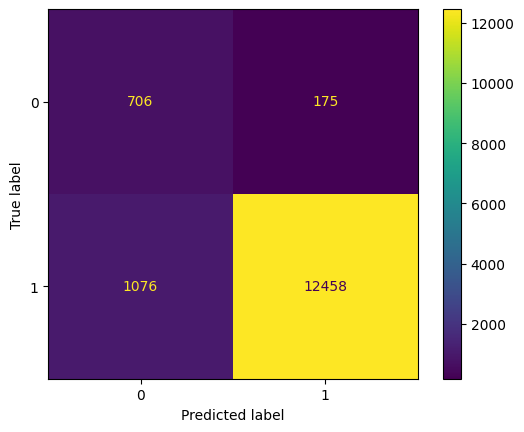

In [482]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are defined
cm = confusion_matrix(y_true, thresholdAnomalies)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [483]:
# 讀取多個 CSV 並合併
splitAttack = pd.read_csv(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')
for i in range(2, 16):
    tmp = pd.read_csv(r'multiclass15\csv_result-data' + str(i) + ' Sampled Scenarios.csv')
    splitAttack = pd.concat([splitAttack, tmp], ignore_index=True)


In [484]:
# 清理數據
normal = splitAttack.replace([np.inf, -np.inf], np.nan).dropna()
normal = normal.drop('id', axis=1)

# 提取標籤為 7, 8, 9, 10, 11, 12 的數據
normal = normal[normal['marker'].isin([41])]

# 儲存到新的 DataFrame
normal = normal.reset_index(drop=True)  # 重置索引

normal = normal.drop('marker', axis=1)

# # 刪除不必要的欄位
columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
normal = normal.drop(columns=columns_to_drop, axis=1)

normal = scaler.transform(normal)

In [485]:
# 清理數據
rscAttack = splitAttack.replace([np.inf, -np.inf], np.nan).dropna()
rscAttack = rscAttack.drop('id', axis=1)

# 提取標籤為 7, 8, 9, 10, 11, 12 的數據
rscAttack = rscAttack[rscAttack['marker'].isin([21,22,23,24,25,26,27,28,29,30,35,36,37,38,39,40])]

# 儲存到新的 DataFrame
rscAttack = rscAttack.reset_index(drop=True)  # 重置索引

rscAttack = rscAttack.drop('marker', axis=1)

# # 刪除不必要的欄位
columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
rscAttack = rscAttack.drop(columns=columns_to_drop, axis=1)

rscAttack = scaler.transform(rscAttack)

In [486]:
# 清理數據
rtciAttack = splitAttack.replace([np.inf, -np.inf], np.nan).dropna()
rtciAttack = rtciAttack.drop('id', axis=1)

# 提取標籤為 7, 8, 9, 10, 11, 12 的數據
rtciAttack = rtciAttack[rtciAttack['marker'].isin([15,16,17,18,19,20])]

# 儲存到新的 DataFrame
rtciAttack = rtciAttack.reset_index(drop=True)  # 重置索引

rtciAttack = rtciAttack.drop('marker', axis=1)

# # 刪除不必要的欄位
columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
rtciAttack = rtciAttack.drop(columns=columns_to_drop, axis=1)

rtciAttack = scaler.transform(rtciAttack)

In [487]:
# 清理數據
djAttack = splitAttack.replace([np.inf, -np.inf], np.nan).dropna()
djAttack = djAttack.drop('id', axis=1)

# 提取標籤為 7, 8, 9, 10, 11, 12 的數據
djAttack = djAttack[djAttack['marker'].isin([7, 8, 9, 10, 11, 12])]

# 儲存到新的 DataFrame
djAttack = djAttack.reset_index(drop=True)  # 重置索引

djAttack = djAttack.drop('marker', axis=1)

# # 刪除不必要的欄位
columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
djAttack = djAttack.drop(columns=columns_to_drop, axis=1)

djAttack = scaler.transform(djAttack)

In [488]:
# 清理數據
NaturalEvent = splitAttack.replace([np.inf, -np.inf], np.nan).dropna()
NaturalEvent = NaturalEvent.drop('id', axis=1)

# 提取標籤為 7, 8, 9, 10, 11, 12 的數據
NaturalEvent = NaturalEvent[NaturalEvent['marker'].isin([21,22,23,24,25,26,27,28,29,30,35,36,37,38,39,40])]

# 儲存到新的 DataFrame
NaturalEvent = NaturalEvent.reset_index(drop=True)  # 重置索引

NaturalEvent = NaturalEvent.drop('marker', axis=1)

# # 刪除不必要的欄位
columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
NaturalEvent = NaturalEvent.drop(columns=columns_to_drop, axis=1)

NaturalEvent = scaler.transform(NaturalEvent)

In [489]:
def prid(data):
    net.eval()
    hyperFeature = []

    with torch.no_grad():      
        X_tensor = torch.tensor(data, dtype=torch.float32)
        X_tensor = X_tensor.to('cuda')

        # 找到你了 小調皮
        outputs = net(X_tensor)

        hyperFeature.append(outputs.cpu().numpy())

    hyperFeatureNP = np.vstack(hyperFeature)
    return hyperFeatureNP

In [490]:
djHF = prid(djAttack)
rtciHF = prid(rtciAttack)
rscHF = prid(rscAttack)

neHF = prid(NaturalEvent)

normalHF = prid(normal)

In [491]:
no = iso_forest.decision_function(normalHF)

noPrid = []
for i in range(len(no)):
    if no[i] < threshold:
        noPrid.append(1)
    else:
        noPrid.append(0)
        
nozero = noPrid.count(0)

In [492]:
ne = iso_forest.decision_function(neHF)

nePrid = []
for i in range(len(ne)):
    if ne[i] < threshold:
        nePrid.append(1)
    else:
        nePrid.append(0)
        
ne1 = nePrid.count(1)

In [493]:
dj = iso_forest.decision_function(djHF)

datainjection = []
for i in range(len(dj)):
    if dj[i] < threshold:
        datainjection.append(1)
    else:
        datainjection.append(0)
        
dj1 = datainjection.count(1)

In [494]:
rtci = iso_forest.decision_function(rtciHF)

RemoteTrippingCommandInjection = []
for i in range(len(rtci)):
    if rtci[i] < threshold:
        RemoteTrippingCommandInjection.append(1)
    else:
        RemoteTrippingCommandInjection.append(0)
        
rtci1 = RemoteTrippingCommandInjection.count(1)

In [495]:
rsc = iso_forest.decision_function(rscHF)

RelaySettingChange = []
for i in range(len(rsc)):
    if rsc[i] < threshold:
        RelaySettingChange.append(1)
    else:
        RelaySettingChange.append(0)
        
rsc1 = RelaySettingChange.count(1)

In [496]:
print(f"dt檢測出來的{dj1},總共{len(datainjection)},{dj1/len(datainjection)}%")
print(f"rsc檢測出來的{rsc1}總共{len(RelaySettingChange)},{rsc1/len(RelaySettingChange)}%")
print(f"rtci檢測出來的{rtci1}總共{len(RemoteTrippingCommandInjection)},{rtci1/len(RemoteTrippingCommandInjection)}%")

dt檢測出來的8123,總共8642,0.9399444573015505%
rsc檢測出來的32574總共35053,0.9292785210966251%
rtci檢測出來的6596總共7750,0.8510967741935483%


In [497]:
print(ne1/len(nePrid))


print(f"這是正確預測正常模式的機率{nozero/len(noPrid)}")

0.9292785210966251
這是正確預測正常模式的機率0.8002270147559591
